Reference:

John R. Ladd, Jessica Otis, Christopher N. Warren, and Scott Weingart, "Exploring and Analyzing Network Data with Python," The Programming Historian 6 (2017), https://doi.org/10.46430/phen0064.

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [1]:
from collections import Counter
import functools
import itertools
from operator import itemgetter
import re
import timeit

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats

from utils import *
from graph_utils import *
from series_utils import *
from topic_utils import *

In [2]:
%matplotlib notebook
plt.style.use("bmh")

pd.options.display.float_format = '{:.2f}'.format

## Graph utilities

In [3]:
def add_node_attributes(G):
    """Compute various graph metrics and add to node attributes.
    """
    # degree
    nx.set_node_attributes(G,
                           dict(G.out_degree(G.nodes())), 
                           'out_degree')
    nx.set_node_attributes(G,
                           dict(G.in_degree(G.nodes())), 
                           'in_degree')
    
    if (type(G) != nx.classes.multidigraph.MultiDiGraph):
        # eigenvector centrality
        nx.set_node_attributes(G, 
                               nx.eigenvector_centrality(G),
                               'eigenvector')

        # betweenness centrality
        nx.set_node_attributes(G,
                               nx.betweenness_centrality(G), 
                               'betweenness')

        # degree centrality
        nx.set_node_attributes(G,
                               nx.degree_centrality(re),
                               'degree_centrality')

In [4]:
def top_nodes(attribute_dict, limit=20, show=False):
    """Return and optionally print the top n nodes in an attribute
    dictionary.
    """
    nodes = sorted(attribute_dict.items(), 
                   key=lambda item: item[1], 
                   reverse=True)[:limit]
    if show:
        print("Top {} nodes:".format(limit))
        for d in nodes:
            print(d)
        
    return nodes
        
def highest_value(attribute_dict):     
    """Find the node with largest value in an attribute dictionary.
    
    Return: 
        tuple(node, value)
        
    """     
    # Ordered tuple
    attr_items = [(b,a) for (a,b) in attribute_dict.iteritems()]    
    # Sort in descending order     
    attr_items.sort()  
    attr_items.reverse()
    return tuple(reversed(attr_items[0]))

### Export

In [5]:
def to_df(G):
    """Export graph to Pandas dataframe with attributes as columns."""
    return pd.DataFrame(dict(G.nodes(data=True))).T
    
def to_file(G, file):
    """Export graph to .gexf file."""
    nx.write_gexf(G, file)
    
def to_txt(G, file):
    """Export node attributes to .txt file."""
    results = [(k, bet_cen[k], clo_cen[k], eig_cen[k]) for k in range(len(nodes))]
    
    f = open(file,'w')
    for item in results:     
        f.write(','.join(map(str,item)))     
        f.write('\n')
    f.close()

def get_matrix(G):
    return nx.to_numpy_matrix(G)

In [6]:
def visualize(G, format_dict=None):
    if format_dict == None:
        format_dict = {'font_size':16,
                       'width':3,
                       'edge_color':'grey',
                       'node_color':'purple',
                       'with_labels':False,
                      }

    fig, ax = plt.subplots(figsize=(10, 8))

    pos = nx.spring_layout(G, k=2)

    nx.draw_networkx(G, 
                     pos,
                     ax=ax,
                     kwargs=format_dict,
                    )
    # Offset labels
    for key, value in pos.items():
        x, y = value[0]+.135, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)

In [7]:
def graph_properties(graph):
    properties = []
    out = "Nodes: {}".format(graph.number_of_nodes())
    properties.append(out)
    print(out)
    
    out = "Edges: {}".format(graph.number_of_edges())
    print(out)
    properties.append(out)
    
    degrees = [val for (node, val) in graph.degree()]
    out = "Maximum degree: {}".format(np.max(degrees))
    properties.append(out)
    print(out)
    
    out = "Minimum degree: {}".format(np.min(degrees))
    properties.append(out)
    print(out)
    
    out = "Average degree: {:.1f}".format(np.mean(degrees))
    properties.append(out)
    print(out)
    
    out = "Mode: {}".format(stats.mode(degrees)[0][0])
    properties.append(out)
    print(out)
    
    return properties

## Build User Graphs

### structure:
MultiDiGraph:
- nodes are userids $\rightarrow$ make nodes from unique ids
- edges are a tweet
- edges are directed (```user1``` ```-retweet>``` ```user2```)
- multiple edges between nodes (```user1``` retweeted ```user2``` multiple times)

In [8]:
def get_unique_ids(campaign, campaign_users):
    campaign_userids = (campaign_users
           .groupby('userid')
           .size()
           .index
          )
    tweet_userids = (campaign
                   .groupby('userid')
                   .size()
                   .index
                  )
    retweet_userids = (campaign
                   .loc[:]['retweet_userid']
                   .dropna()
                  )    
    reply_userids = (campaign
                   .loc[:]['in_reply_to_userid']
                   .dropna()
                  )
    mention_userids = (campaign['user_mentions']
                # expand usernames into columns
                .explode()
                # melt wide table into duplicated tweets
                .reset_index()
                .melt(id_vars=['tweetid'],
                      value_name='mentioned_userid')
                # clean up
                .astype({'mentioned_userid':'string'})
                .drop(columns=['variable'])
                .join(campaign['userid'], on='tweetid')
                .dropna()
               ).loc[:]['mentioned_userid']
    
    return Counter(list(itertools.chain(*[campaign_userids,
                                            tweet_userids,
                                            retweet_userids,
                                            reply_userids,
                                            mention_userids,
                                           ])))

In [9]:
def make_user_graph(campaign):
    
    unique_ids = dict(get_unique_ids(campaign, campaign_users))
    id_df = pd.DataFrame(data=unique_ids.values(),
                     index=unique_ids.keys(),
                     columns=['tweet_count'])
    id_df['in_campaign'] = (id_df.index).isin(campaign_users.index)

    user_graph = nx.Graph()
    user_nodes = user_graph.add_nodes_from(id_df.index, 
                            count=id_df.tweet_count, 
                            in_campaign=id_df.in_campaign,
                           )
    return user_graph
    
def make_connection_graph(tweetid, user1, user2, user_graph):

    graph = nx.MultiDiGraph(user_graph)

    tweetids = [dict(tweetid=tid) for tid in tweetid]
    graph.add_edges_from(list(zip(user1,
                                     user2,
                                     tweetids)))
    add_node_attributes(graph)
    
    return graph

In [10]:
fields = ['user_display_name',
       'user_reported_location',
       'user_profile_description',
       'follower_count',
       'following_count']

## Example: Iran 12/2020 Campaign

In [11]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [12]:
tweets_df = tweets.df.loc[:][:]
users_df = users.df.loc[:][:]

In [13]:
campaign = tweets_df[tweets_df['campaign'] == 'iran202012']
campaign_users = users_df[users_df['campaign'] == 'iran202012']

In [14]:
user_graph = make_user_graph(campaign)

In [51]:
retweets = (campaign
  .loc[:][['userid','retweet_userid']]
  .dropna()
  .reset_index()
 )
retweets['in_campaign'] = retweets['retweet_userid'].isin(campaign_users.index)

retweet_graph = make_connection_graph(retweets['tweetid'],
                                 retweets['userid'],
                                 retweets['retweet_userid'],
                                 user_graph)

In [52]:
replies = (campaign
          .loc[:][['userid', 'in_reply_to_userid']]
          .dropna()
          .reset_index()
         )

replies['in_campaign'] = replies['in_reply_to_userid'].isin(campaign_users.index)

reply_graph = make_connection_graph(replies['tweetid'],
                                    replies['userid'],
                                    replies['in_reply_to_userid'],
                                    user_graph)

In [53]:
mention_userids = (campaign['user_mentions']
            # expand usernames into columns
            .explode()
            # melt wide table into duplicated tweets
            .reset_index()
            .melt(id_vars=['tweetid'],
                  value_name='mentioned_userid')
            # clean up
            .astype({'mentioned_userid':'string'})
            .drop(columns=['variable'])
            .join(campaign['userid'], on='tweetid')
            .dropna()
          )
    
mentions = (mention_userids
            .loc[:][['userid','mentioned_userid','tweetid']]
            .query('mentioned_userid != ""')
           )

mentions['in_campaign'] = mentions['mentioned_userid'].isin(campaign_users.index)

mention_graph = make_connection_graph(mentions['tweetid'],
                                      mentions['userid'],
                                      mentions['mentioned_userid'],
                                      user_graph)

In [18]:
properties = graph_properties(retweet_graph)

Nodes: 61117
Edges: 17981
Maximum degree: 9737
Minimum degree: 0
Average degree: 0.6
Mode: 0


In [19]:
properties = graph_properties(reply_graph)

Nodes: 61117
Edges: 95096
Maximum degree: 13301
Minimum degree: 0
Average degree: 3.1
Mode: 0


In [20]:
properties = graph_properties(mention_graph)

Nodes: 61117
Edges: 288206
Maximum degree: 42752
Minimum degree: 0
Average degree: 9.4
Mode: 1


## Node degrees

In the user graphs, given that edges represent tweets, we can use the metric of node degree to understand how the users interacted with each other, with degree indicating tweet volume. The graphs are directed multigraphs, reflecting the fact that tweet relationships are directed (i.e. retweeting is different from being retweeted), and that a given user may have retweeted more than one of another user's tweets. As such, we make a distinction between incoming degree and outgoing degree.

In [21]:
def top_node_degrees(graph, limit=20):
    most_output = top_nodes(nx.get_node_attributes(graph, 'out_degree'),limit=limit)
    most_input = top_nodes(nx.get_node_attributes(graph, 'in_degree'),limit=limit)
    common_users = [userid for userid in dict(most_input).keys() 
                    if userid in dict(most_output).keys()]
    
    return most_output, most_input, common_users

### Retweets

In the case of retweets, we understand outgoing degrees as a measure of propagation of tweets, where a high outgoing degree indicates a high propagator role. A high incoming degree indicates that a user's content is highly propagated.

In [54]:
retweets['in_campaign'].value_counts()

True    17981
Name: in_campaign, dtype: int64

In [23]:
most_retweets, most_retweeted, common_rt = top_node_degrees(retweet_graph)

In [24]:
most_retweets

[('213589457', 4857),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 2025),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 1522),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 1453),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 1336),
 ('6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=', 649),
 ('794097607845015552', 625),
 ('QXyUcPxvoQ+uzkqCj6O+AT9nUf3Avh0JTvwTG9GncQk=', 581),
 ('A2ufeZxtC32uuqgSKfm1EiJPs4uMP3aM7AfHUMsTM=', 571),
 ('Hz3n1y2y3sLOknEGxPWczYyCSeZrz15JLPTcJAd6oAo=', 569),
 ('EOkiPW6kT+GE5A2wU5mqPe7hiK8s7Cr0tfCybFsz2Sg=', 523),
 ('ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=', 403),
 ('1091795789263921152', 371),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 293),
 ('LubegkQHPmV20BdQonItq03iWY5unAkvlI2M7PNKvjI=', 241),
 ('1067814896706994176', 211),
 ('xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=', 158),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 155),
 ('6UQXw4Mnf0c4YkJ5rSJWtgfZlNBQFdx38mOzYUt16sI=', 133),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 124)

In [25]:
most_retweeted

[('213589457', 4880),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 2623),
 ('1067814896706994176', 2407),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 1783),
 ('794097607845015552', 625),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 545),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 544),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 529),
 ('6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=', 505),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 445),
 ('1091795789263921152', 371),
 ('ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=', 366),
 ('mpY+AZI80Nu61VS3o4Zm+UXTjaxrkE08xU0nO3JQ=', 342),
 ('EOkiPW6kT+GE5A2wU5mqPe7hiK8s7Cr0tfCybFsz2Sg=', 299),
 ('1099221870530961408', 215),
 ('XCVp3AesS42sNbyxhBsKM62AylqUJyipi3laS53gY=', 168),
 ('6UQXw4Mnf0c4YkJ5rSJWtgfZlNBQFdx38mOzYUt16sI=', 133),
 ('QXyUcPxvoQ+uzkqCj6O+AT9nUf3Avh0JTvwTG9GncQk=', 133),
 ('xkCWfX+FKOlOHNYjW1jeAG4IfrkxhOZLVbgnDWHVevg=', 109),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 106)]

We see that most of the top 20 propagators and are also among the top 20 creators (as measured by retweet relationship):

In [26]:
len(campaign_users
 .loc[common_rt][fields]
)

17

In [27]:
(campaign_users
 .loc[common_rt][fields]
)

,user_display_name,user_reported_location,user_profile_description,follower_count,following_count
userid,,,,,
213589457,HispanTV,Teherán,"Medio no corporativo, que se hace eco de las r...",161512,31
Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=,Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=,<NA>,Freelance Journalist 📝 Middle-Eastern Politics...,2499,2701
1067814896706994176,Fatma Nursani,"Jakarta Barat, DKI Jakarta",أَمَّنْ يُجِيبُ الْمُضْطَرَّ إِذَا دَعَاهُ وَي...,5292,2384
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,Jakarta,"Pejuang keadilan 💪✊🇮🇩 Yang belum kefollow, in...",4436,2613
794097607845015552,Political Economy,<NA>,<NA>,5578,596
BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=,BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=,"Jakarta Selatan, DKI Jakarta",Account that fought for the oppressed countrie...,2485,1619
79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=,79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=,"Jakarta Selatan, DKI Jakarta",Indonesian 🇮🇩 😘 Middle Eastern Activist 💪🏻 Ant...,2536,2419
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,<NA>,in God we Trust,745,794
6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=,6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=,Indonesia,sharing my happy thoughts 🌹,584,383


### Replies

We can also observe replies as an indication of interactivity among campaign users. Further analysis could for instance identify and analyze chains of replies composing a conversation between a pair of users.

In [55]:
replies['in_campaign'].value_counts()

False    87913
True      7183
Name: in_campaign, dtype: int64

In [29]:
most_replying, most_replied, common_re = top_node_degrees(reply_graph)

In [30]:
most_replying

[('0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=', 13282),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 10258),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 8118),
 ('XpT328jUSYUJJM4Bt0HmKSJ8d8rJWgkBkQhdff62skE=', 6296),
 ('WFMM2eW8YAMex3B1z4P8vxx0OvkEJvFCx9l0uYGMqug=', 5969),
 ('1091795789263921152', 5086),
 ('1067814896706994176', 4852),
 ('wqcue0aByZjWGy2aKzh3IiKOK3urEeCGmRPpbpfvPBc=', 2703),
 ('1099221870530961408', 1832),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 1774),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 1746),
 ('mpY+AZI80Nu61VS3o4Zm+UXTjaxrkE08xU0nO3JQ=', 1427),
 ('DsqKOBIbyhdb1fRCREnRRabr2ijPMzNgximA+u8N8=', 1233),
 ('iVnWPNBGsoPoOI0d759LSmf2u0DGfCCHSznVuHLNjo=', 1218),
 ('lTQFNj2OGHS3yOz2SZimhktwdgrQmMsXUuaGHi7zek=', 1125),
 ('tfIRka6bXJoCm84UisMb2m4L8XpKyPJr7Yfv8UmeQ=', 1109),
 ('6UQXw4Mnf0c4YkJ5rSJWtgfZlNBQFdx38mOzYUt16sI=', 1075),
 ('5O68KDqdztRXhsl9HkNpWLfdwjINlgxlCDiKbBCFzzc=', 982),
 ('wBrHiyqOL5uBhytBGwy2W3A8nDXyRNfgAXfqXn3e0GY=', 982),
 ('eb

In [31]:
# most-replying user
most_re_userid = most_replying[0][0]

In [32]:
# account doesn't have much information
(campaign_users
 .loc[most_re_userid][fields+['account_creation_date','account_language']]
)

user_display_name           0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=
user_reported_location                                              <NA>
user_profile_description                                            <NA>
follower_count                                                        68
following_count                                                       57
account_creation_date                                2013-02-27 00:00:00
account_language                                                      fa
Name: 0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=, dtype: object

In [33]:
most_re_user = (campaign
 .groupby('userid')
 .get_group(most_re_userid)
)

In [35]:
most_re_user[['tweet_text','hashtags','user_mentions']]

,tweet_text,hashtags,user_mentions
tweetid,,,
1315368545782566912,@VoteMarsha Why Women Prefer to Vote for an ra...,[],[63150856]
1266259765123923968,@SteveGelder After 20 years of screaming about...,[],[382340056]
1262005607655256065,@MrE1310 @JamesGRickards Only 14 billion usd o...,[],"[1247103535579197440, 93295809]"
1314411696308596738,@bfraser747 @realDonaldTrump @JoeBiden @Kamala...,[],"[274891222, 25073877, 939091, 30354991, 15..."
1303026114990870531,@BW Biden Immigration Amnesty Could Lead To As...,[],"[67358777, 3066129832]"
...,...,...,...
1265998829469433857,@RebeccaFlair @passport_cutty Silver is tradin...,[],"[285635271, 359416159]"
433672115108061185,اینترنت زغالی,NaN,[]
1312684338547482625,@king_Mulroney Vote biden = millions and milli...,[],[236273373]


In [36]:
most_re_user_timeline = make_timeline(most_re_user, 'd')

<IPython.core.display.Javascript object>


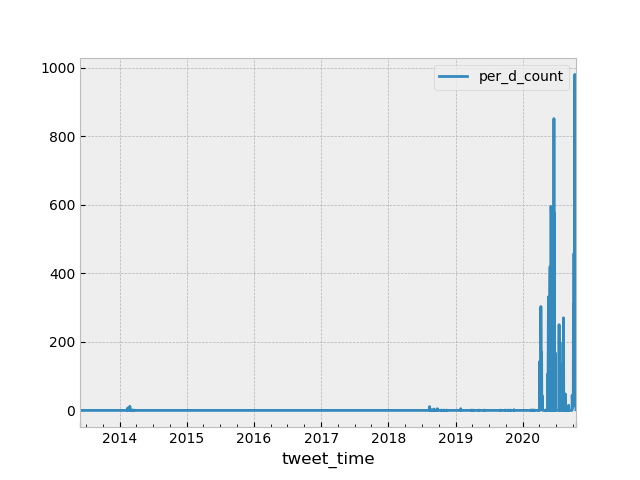

In [37]:
most_re_user_timeline.plot()

In [38]:
most_replied

[('25073877', 6440),
 ('759251', 5264),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 1686),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 1666),
 ('47448563', 693),
 ('EOkiPW6kT+GE5A2wU5mqPe7hiK8s7Cr0tfCybFsz2Sg=', 635),
 ('2467791', 608),
 ('2836421', 540),
 ('QXyUcPxvoQ+uzkqCj6O+AT9nUf3Avh0JTvwTG9GncQk=', 529),
 ('138212728', 513),
 ('790728', 487),
 ('410718052', 475),
 ('128262354', 420),
 ('irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8I=', 350),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 344),
 ('1285276850411864065', 316),
 ('5bXQzilfbR70wndojgGtIlSmUsL8W8RbAPssGLY0Y=', 302),
 ('1009577803304656896', 298),
 ('818910970567344128', 295),
 ('374729426', 291)]

In [39]:
(campaign_users
 .loc[common_re][fields]
)

,user_display_name,user_reported_location,user_profile_description,follower_count,following_count
userid,,,,,
rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=,rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=,<NA>,Treat others the way you'd like to be treated ...,2911,2441
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=,<NA>,in God we Trust,745,794


### Mentions

Mentions can indicate an original message which is directed at the mentioned user, i.e. a tweet addressed to a user which is not specifically in reply to an existing tweet.

In [ ]:
mentions

In [41]:
most_mentions, most_mentioned, common_me = top_node_degrees(mention_graph)

In [42]:
most_mentions

[('213589457', 42752),
 ('1235289416370774016', 23375),
 ('0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=', 23120),
 ('T8AyWQK3ajadJJL2J+OJovSr4z+rpoK4LqM6ob+wTw=', 22923),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 14665),
 ('1067814896706994176', 11811),
 ('WFMM2eW8YAMex3B1z4P8vxx0OvkEJvFCx9l0uYGMqug=', 8936),
 ('XpT328jUSYUJJM4Bt0HmKSJ8d8rJWgkBkQhdff62skE=', 8023),
 ('A8dbNc6R+dK0Ml02nrs1gjJKz9HIHRqLkcIixDiREoM=', 7997),
 ('1091795789263921152', 6760),
 ('fOKnPXaJon5pH9ZoHgWWQG+L1TdWue7y5OAPSPhLZs=', 5706),
 ('rrkP3RNDiwWqLySjcoqdFlz7DrFX7RCwwDSxyDqaU=', 5413),
 ('79Tf6XH3DwjdUWGO4aQWghSj5G2esetBnePoOBB3wYM=', 5110),
 ('z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=', 4412),
 ('6qhrzJLryTiE7VlJkmY+cKE5VsITiaFwMA7s3Dr5I=', 4296),
 ('ihPCMQ32xEzpD35Et9IH4HO21XKiWdSJreVg+pHT5o=', 3923),
 ('BYaaZkKxjVQjhsnn9REZ0UcFoEHl+tKnzJ+0Hv+Pg=', 3868),
 ('1099221870530961408', 3479),
 ('wqcue0aByZjWGy2aKzh3IiKOK3urEeCGmRPpbpfvPBc=', 3433),
 ('794097607845015552', 3380)]

In [43]:
most_mentioned

[('10228272', 34405),
 ('25073877', 7660),
 ('759251', 5409),
 ('irXcL8Y80STibhjlS3a48BahFUg3yqPT+XtTxkpLL8I=', 4901),
 (' 25073877', 3219),
 ('Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=', 2744),
 ('5bXQzilfbR70wndojgGtIlSmUsL8W8RbAPssGLY0Y=', 2573),
 ('etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=', 1964),
 ('1172112779815399424', 1759),
 ('1252764865', 1688),
 ('150573137', 976),
 ('1640929196', 727),
 ('47448563', 700),
 (' 939091', 694),
 ('1212304197627998209', 675),
 ('2467791', 647),
 ('1215636956291510274', 626),
 ('iMu6Ukwlry6PiiRnPSE710AKRlyOVlncYVaHAY9tRU4=', 625),
 ('1175350204628787200', 611),
 ('1009577803304656896', 601)]

In [44]:
(campaign_users
 .loc[common_me][fields]
)

,user_display_name,user_reported_location,user_profile_description,follower_count,following_count
userid,,,,,
etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=,Jakarta,"Pejuang keadilan 💪✊🇮🇩 Yang belum kefollow, in...",4436,2613


In [45]:
most_mentioned[0][0]

'10228272'

In [46]:
mentions = [user[0] for user in most_mentioned
           if user[0] in campaign_users.index]
mentions

['Bl9IUxp6GStTkiNGbhfBJM9xu85e3Y9BQdNd97GFAI=',
 'etDaWEjMPleueDrpkatPUSCApc6yU8W95+yZYWzVxSY=']

In [48]:
re['campaign_user'] = re['in_reply_to_userid'].isin(campaign_users.index)
re['campaign_user'].value_counts()

TypeError: 'module' object is not subscriptable

In [ ]:
mentions['campaign_user'] = mentions['mentioned_userid'].isin(campaign_users.index)
mentions['campaign_user'].value_counts()

## Other
In addition to looking at the multigraph which considers tweet volume between users, we can collapse the multigraph to a digraph and consider simply the presence/absence of a directed relationship between users.

TODO: tweet volume as edge weight?

### Connectivity: Density, clustering, transitivity

Measuring the tendency for nodes to cluster together or for edges to form triangles: this corresponds to measures of the extent to which the users interacting with one particular user tend to interact with each other as well. These metrics can provide insight into how users tend to create groups characterized by dense connections.

- Density describes the ratio of graph edges to the number of edges if the graph were fully connected.

- The clustering coefficient is calculated as the number of triangles connected to node $i$ divided by the number of sets of two edges connected to node $i$ (node triples). 

- The transitivity coefficient is calculated as 3 times the number of triangles in the network, divided by the number of connected triples of nodes in the network. Transitivity weights nodes with a large degree higher.

In [ ]:
# not defined for MultiDiGraph
digraph = nx.DiGraph(rt_graph)

In [ ]:
print('Retweets:')
out = 'Density: {}'.format(nx.density(digraph))
print(out)
out = "Average clustering coefficient: {}".format(nx.average_clustering(digraph))
print(out)
out = "Transitivity: {}".format(nx.transitivity(digraph))
print(out)

### Undirected attributes
A further reduction is to consider the presence/absence of connection between users without making the directed distinction between propagator/propagated:

In [ ]:
def add_undirected_attributes(G):
    
    G.graph['connected_components'] = nx.number_connected_components(graph)
    
    clustering_coeffs = nx.clustering(graph)
    G.graph['avg_clust'] = (sum(clustering_coeffs.values()) 
                             / len(clustering_coeffs)) 

In [ ]:
# not defined for DiGraph
graph = nx.Graph(digraph)
add_undirected_attributes(graph)

In [ ]:
out = 'Connected components: {}'.format(nx.number_connected_components(graph))
print(out)

clustering_coeffs = nx.clustering(graph)
out = 'Avg. clustering coefficient: {}'.format(sum(clustering_coeffs.values()) 
                             / len(clustering_coeffs))
print(out)

### Centrality

Capture the importance of a node's position in the network considering: 
- degree, on the assumption that an important node will have many connections
- closeness, on the assumption that important nodes are close to other nodes

In [ ]:
graph_centrality = nx.degree_centrality(graph)
sorted(graph_centrality.items(), 
       key=lambda item: item[1],
       reverse=True)[:5]

In [ ]:
graph_closeness = nx.closeness_centrality(graph)
sorted(graph_closeness.items(),
       key=lambda item: item[1],
       reverse=True)[:5]

## To do
- In general, these measures show the sparsity of direct tweet connections among users in the total user graph. Further analysis could search for denser subsets of the overall graph.
- Beyond identifying the most active users in both directions, further analysis can apply topic and sentiment analysis to the tweets of top propagators and creators, to see e.g. what messages the campaign was emphasizing by retweeting itself